In [1]:
from collections import defaultdict
import evaluate
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

/home/mkersten/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Labels for charts, tables
models = {'electra-base-discriminator': 'ELECTRA', 'google': 'ELECTRA', 'google/electra-base-discriminator': 'ELECTRA', 'roberta-base': 'RoBERTa', 'bert-base-uncased': 'BERT', 'distilbert-base-uncased': 'DistilBERT', 'elmo':'ELMo'}
labels = {'accuracy': 'A', 'precision': 'P', 'recall': 'R', 'f1': 'F1'}

### Visualization on **text length** distribution

##### - Visualize word count distribution after preprocessing 

In [67]:
# Load baseline test data
path_to_baseline = "pipeline/text-based/data/text-based-test.csv"
df_baseline = pd.read_csv(path_to_baseline, usecols=['ID','text', 'label'],index_col='ID', nrows=359).dropna()
df_baseline["label"] = df_baseline["label"].map({"FAKE": 0, "REAL": 1})

# 1. Add column with number of words
df_baseline['word_count'] = df_baseline['text'].str.split().apply(len)
df_baseline.drop('text', axis=1, inplace=True)


display(df_baseline.head(2))
print(df_baseline.shape)

,label,word_count
ID,,
1197,1,7
1034,1,206


(357, 2)


In [68]:
# Load test arg-bassd data
path_to_arg = "pipeline/argumentation-based/argumentation structure/dolly/test.csv"
df_arg = pd.read_csv(path_to_arg, index_col='ID', usecols=['ID', 'text', 'label'], nrows=359)
df_arg["label"] = df_arg["label"].map({"FAKE": 0, "REAL": 1})

# 1. Add column with number of words
df_arg['word_count'] = df_arg['text'].str.split().apply(len)
df_arg.drop('text', axis=1, inplace=True)

display(df_arg.head(2))
print(df_arg.shape)

,label,word_count
ID,,
1197,1,17
9795,0,5


(359, 2)


[]

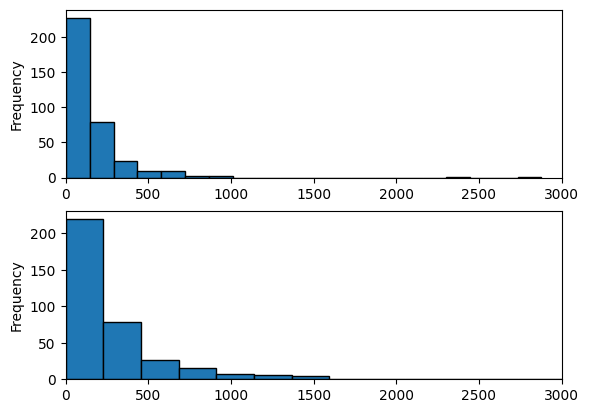

In [78]:
# Arg plot distribution lengths
fig, ax = plt.subplots(2, 1)
# Plot distribution baseline
df_baseline['word_count'].plot(kind='hist', bins=20, edgecolor='black', ax=ax[0])
# plt.xlim(0, 12000)
df_arg['word_count'].plot(kind='hist', bins=20, ax=ax[1], edgecolor='black')
ax[0].set_xlim(0, 3000)  # Set the X-axis limits for the first subplot
ax[1].set_xlim(0, 3000)  # Set the X-axis limits for the second subplot
plt.plot()


##### - Visualize F1 score depending on word count

TODO:
1. Kolom met lengte nieuws artikel toevoegen op test set.
2. Logische categorieën bedenken voor woorden
3. Modellen op baseline en argument component pipeline model runnen op unlabeled test data.
4. Predictions FAKE/REAL opslaan per artikel
4. 'Handmatig' de F1 berekenen per logisch bedachte categorie lengte woorden stap 2.
5. Lineplot of barplot maken met Y F1 accuracy en X lengte woorden.

In [316]:
# Replace by best model
BEST_MODEL = 'distilbert-base-uncased'

In [317]:
def get_labels(path_to_labels):
    df_labels = pd.read_csv(f"{path_to_labels}/test.csv", usecols=['ID', 'text', 'label'], index_col='ID')
    df_labels["label"] = df_labels["label"].map({"FAKE": 0, "REAL": 1})
    df_labels['word_count'] = df_labels['text'].str.split().apply(len)
    # print(df_labels['word_count'])
    df_labels = add_bins(df_labels, 75, 1000)

    # df_labels = df_labels[['label', 'bin_id']]
    return df_labels

def add_bins(df, bin_size, max_bin):
    # Put word counts in array
    word_count_array = df['word_count'].to_numpy()

    # Prepare bins
    bins = list(np.arange(min(word_count_array), max_bin, bin_size))
    bins.append(np.inf)  # Add one infinity bin for all the outliers
    
    # Assign bin IDs to texts
    df['bin_id'] = pd.cut(df['word_count'], bins=bins, right=True)
    
    return df

In [318]:
metric = evaluate.combine(["f1"])

def process_predictions(df_labels, path_to_predictions):

    # Load predicted labels
    df_predictions = pd.read_csv(f"{path_to_predictions}/{BEST_MODEL}_predictions.csv", usecols=['ID', 'prediction'], index_col='ID')

    # Combine predictions and correct labels
    df = pd.concat([df_labels, df_predictions], axis=1)

    # Calculate F1 score per bin
    grouped_df = df.groupby('bin_id')

    f1_per_batch = []
    for idx, data in grouped_df:
        # print(idx, len(data))
        labels = data['label'].values
        preds = data['prediction'].values
        result = metric.compute(labels, preds)
        f1_per_batch.append(result['f1'])
    
    return f1_per_batch

In [324]:
def plot_lines(performance, ax):
    fig_labels = [i for i in performance]
    y_values = [performance[i] for i in performance]
    x_values = np.arange(1, len(y_values[0]) + 1)

    for i in range(len(y_values)):
        ax.plot(x_values, y_values[i], label=fig_labels[i])
    
    return ax

def get_per_element(path_to_labels, path_to_preds):
    performance = {}
    df_labels = get_labels(path_to_labels)

    for el in ['structure', 'claim', 'evidence']:
        f1_scores = process_predictions(df_labels, f"{path_to_preds}/{el}")
        performance[el] = f1_scores
    return performance

In [330]:
baseline_path_to_labels = "pipeline/text-based/data/"
baseline_path_to_preds = "pipeline/text-based/results"
performance_baseline = process_predictions(get_labels(baseline_path_to_labels), baseline_path_to_preds)
print(performance_baseline)


FileNotFoundError: [Errno 2] No such file or directory: 'pipeline/text-based/results/distilbert-base-uncased_predictions.csv'

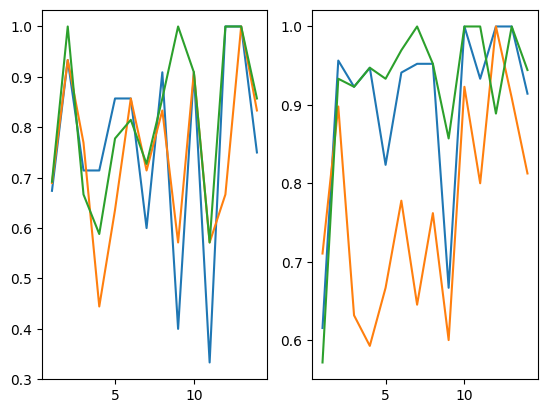

In [325]:
path_to_labels = "pipeline/argumentation-based/argumentation structure"
path_to_preds = "pipeline/argumentation-based/results"

performance_margot = get_per_element(f"{path_to_labels}/margot", f"{path_to_preds}/margot/")
performance_dolly = get_per_element(f"{path_to_labels}/dolly", f"{path_to_preds}/dolly/")

with open('perf_dolly.json', 'w') as json_file:
    json.dump(performance_dolly, json_file, indent=4)

fig, ax = plt.subplots(1, 2)
ax[0] = plot_lines(performance_dolly, ax[0])
ax[1] = plot_lines(performance_margot, ax[1])

evidence
claim
structure


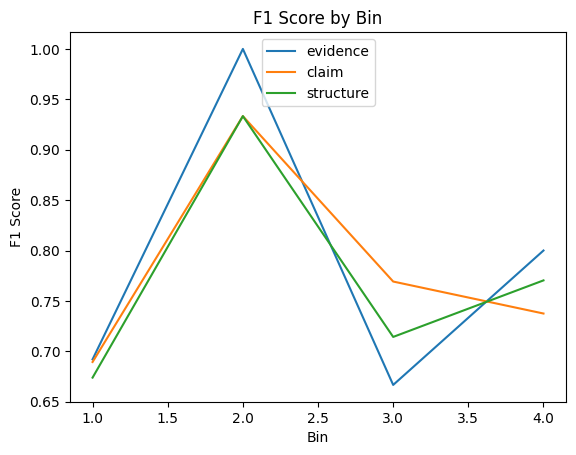

{'evidence': [0.6920415224913494, 1.0, 0.6666666666666667, 0.8], 'claim': [0.6894197952218429, 0.9333333333333333, 0.7692307692307692, 0.7375], 'structure': [0.6739130434782609, 0.9333333333333333, 0.7142857142857143, 0.7703703703703704]}


In [273]:
path_to_dolly = "pipeline/argumentation-based/argumentation structure/dolly/test.csv"
df_labels = get_labels(path_to_dolly)

path_to_dolly_results = "pipeline/argumentation-based/results/dolly"
performance_dolly = process_predictions(df_labels, path_to_dolly_results)

In [ ]:
# # Predict MARGOT
# path_to_margot = "pipeline/argumentation-based/argumentation structure/margot/test.csv"
# path_to_margot_results = "pipeline/argumentation-based/results/margot"

# metrics = evaluate.combine(["f1"])



# performance = defaultdict(dict)
# for el in os.listdir(path_to_margot_results):
#     for f in os.listdir(f"{path_to_margot_results}/{el}"):
#         if f.endswith('.csv'):
#             name = models[' '.join(f.split('_')[:1])]

#             # Load predicted labels
#             df_predictions = pd.read_csv(f"{path_to_margot_results}/{el}/{f}", usecols=['ID', 'prediction'], index_col='ID')

#             # Combine predictions and correct labels
#             df = pd.concat([df_labels, df_predictions], axis=1)

#             grouped_df = df.groupby('bin_id')
#             performance_per_batch = {}
#             for idx, data in grouped_df:
#                 print(idx, len(data))
#                 results = metrics.compute(predictions=data['prediction'].values, references=data['label'].values)

#                 performance_per_batch[idx] = results['f1']
#             performance[el][name] = performance_per_batch



### Visualization on **validation** set

In [ ]:
MODE = 'argumentation-based'
if MODE == 'argumentation-based':
    TOOL = 'margot'
    ELEMENT = 'structure'

    input_path = f"models/{MODE}/{TOOL}/{ELEMENT}/training/"
    output_path = f'pipeline/{MODE}/results/figures/{TOOL}_{ELEMENT}.png'
else:
    input_path = f"models/{MODE}/training/"
    output_path = f'pipeline/{MODE}/results/figures/baseline.png'

In [ ]:
# Plot results baseline

res = defaultdict(dict)
x_values, y_values, hue_values = [], [], []

for root, dirs, files in os.walk(input_path):
    mets = []
    for file in files:

        # Look for trainer_state.json files for all models except for ELMo 
        if file == 'trainer_state.json':
            # PREPARE FOR TABLE
            metrics = {}

            model_name = os.path.basename(os.path.dirname(os.path.dirname(root)))
            dataset = os.path.basename(os.path.dirname(root))
            trainer_state = os.path.join(root, file)

            with open(trainer_state) as f:
                data = json.load(f)

            f1 = data["log_history"][1]["eval_f1"]
            accuracy = data["log_history"][1]["eval_accuracy"]
            recall = data["log_history"][1]["eval_recall"]
            precision = data["log_history"][1]["eval_precision"]

            metrics['F1'] = "{:.2f}".format(f1)
            metrics['Accuracy'] = "{:.2f}".format(accuracy)
            metrics['Recall'] = "{:.2f}".format(recall)
            metrics['Precision'] = "{:.2f}".format(precision)

            res[models[model_name]][datasets[dataset]] = metrics

            # PREPARE FOR CHART 
            x_values.append(models[model_name])
            hue_values.append(datasets[dataset])
            y_values.append(float("{:.2f}".format(f1)))

        # Prepare doing the same for ELMo
        if 'elmo' in os.path.dirname(root):
            if file.endswith('.json'):
                mets.append(file)    
    
    # All ELMo from here
    mets_sorted = sorted(mets, key=lambda x: int(x.split(".")[0][-1]), reverse=True) # Only keep best EPOCH

    if mets_sorted:
        metrics = {}
        model_name = os.path.basename(os.path.dirname(root))
        dataset = os.path.basename(root)
        best_metric = mets_sorted[0]
        best_mets_file = os.path.join(root, best_metric)

        with open(best_mets_file) as f:
            data = json.load(f)
        
        f1 = data["best_validation_f1"]
        accuracy = data["best_validation_accuracy"]
        precision = data["best_validation_precision"]
        recall = data["best_validation_recall"]

        metrics['Accuracy'] = "{:.2f}".format(accuracy)
        metrics['Precision'] = "{:.2f}".format(precision)
        metrics['Recall'] = "{:.2f}".format(recall)
        metrics['F1'] = "{:.2f}".format(f1)

        
        res[models[model_name]][datasets[dataset]] = metrics

        # PREPARE FOR CHART
        x_values.append(models[model_name])
        hue_values.append(datasets[dataset])   
        y_values.append(float("{:.2f}".format(f1)))

In [ ]:
res

In [ ]:
# F1 table only
index = res.keys()
values = []
cols = []

for model_name, d in res.items():
    tmp_cols = []

    for dataset, scores in d.items():
        for metric, score in scores.items():
            if metric == 'F1':
                values.append(score)
                tmp_cols.append((dataset, metric))

cols.append(tmp_cols)

# Flatten columns
cols = sum(cols, [])

multi_index = pd.MultiIndex.from_tuples(cols)

# Reshape the values
reshaped_values = np.array(values).reshape(-1, len(index))  

df = pd.DataFrame(reshaped_values, index=multi_index, columns=index)
df = df.T

df = df.reindex(index=['BERT', 'RoBERTa', 'DistilBERT', 'ELECTRA', 'ELMo'])

print(df.to_latex())

In [ ]:
# Full table (A, P, R, F1)
# Create table with 2 level index (dataset, metric), columns are the models, values are the scores
reformed = []
for k, v in res.items():
    x = {(outerKey, innerKey): values for outerKey, innerDict in v.items() for innerKey, values in innerDict.items()}
    y = pd.DataFrame(x, index=[k])
    reformed.append(y)

df = pd.concat(reformed)
df = df.reindex(index=['BERT', 'RoBERTa', 'DistilBERT', 'ELECTRA', 'ELMo'])
df


In [ ]:
# For thesis
print(df.to_latex())

In [ ]:
sns.set_style("whitegrid")
sns.set_context('paper')

plt.figure(figsize=(6, 4))

ax = sns.barplot(x=x_values, y=y_values, hue=hue_values, palette="deep")
sns.move_legend(ax, "lower center", 
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)

ax.set_yticks(list(np.arange(0,1.1,0.1)))
plt.ylabel('F1')

plt.savefig(f"{output_path}.png")

### Visualisation on **test** set

#### Baseline pipeline

In [ ]:
# Concat inference results
path_to_txt_json = "pipeline/text-based/results/json"

performance = {}
for file_name in os.listdir(path_to_txt_json):
    path = os.path.join(path_to_txt_json, file_name)
    if file_name != '.ipynb_checkpoints':
        with open(path) as f:
            json_results = json.load(f)
            performance.update(json_results)

In [ ]:
# F1 table only
idx, values, cols = [], [], []

for model, scores in performance.items():
    for metric, score in scores.items():
        if metric == 'f1':
            idx.append(models[model])
            values.append(score)
            cols.append(('baseline', metric))

multi_columns = pd.MultiIndex.from_tuples([('baseline', 'f1')])
multi_columns

df = pd.DataFrame(values, index=idx, columns=multi_columns)
df

In [ ]:
# Full table (A, P, R, F1)
# Create table with 2 level index (dataset, metric), columns are the models, values are the scores

idx = [models[i] for i in performance]

columns = [[('baseline', j) for j in performance[i]] for i in performance]

values = [["{:.2f}".format(performance[i][j]) for j in performance[i]] for i in performance]

multi_columns = pd.MultiIndex.from_tuples(columns[0])
reshaped_values = np.array(values)#.reshape(len(index), -1)  
df = pd.DataFrame(reshaped_values, index=idx, columns=multi_columns)

display(df)
print(df.to_latex())

#### Argumentation-based pipeline

In [ ]:
# Concat inference results
path_to_dolly = "pipeline/argumentation-based/results/dolly"

performance_dolly = {}
for component_name in os.listdir(path_to_dolly):
    path_to_json = f"{path_to_dolly}/{component_name}/json"
    for f in os.listdir(path_to_json):
        path = os.path.join(path_to_json, f)
        with open(path) as f:
            json_results = json.load(f)
            performance_dolly[component_name] = json_results
print(performance_dolly)

In [ ]:
path_to_margot = "pipeline/argumentation-based/results/margot"

performance_margot = {}
for component_name in os.listdir(path_to_dolly):
    path_to_json = f"{path_to_margot}/{file_name}/json"
    for f in os.listdir(path_to_json):
        path = os.path.join(path_to_json, f)
        with open(path) as f:
            json_results = json.load(f)
            performance_margot[component_name] = json_results
print(performance_margot)

In [ ]:
# Dolly: Full table (A, P, R, F1)
cols, values = [], []
for i in performance_dolly:
    tmp_col, idx = [], []
    for k, v in performance_dolly[i].items():

        idx.append(models[k])

        metric = [(i,labels[j]) for j in performance_dolly[i][k]]
        value = [(performance_dolly[i][k][j]) for j in performance_dolly[i][k]]
        for a, b in performance_dolly[i][k].items():
            value = "{:.2f}".format(b)
            values.append(value)

    cols.append(metric)

cols = sum(cols, [])
multi_columns = pd.MultiIndex.from_tuples(cols, names=['component', 'metric'])
reshaped_values = np.array(values).reshape(-1, 12)  
df_dolly = pd.DataFrame(reshaped_values, index=idx, columns=multi_columns)
display(df_dolly)
print(df_dolly.to_latex())

In [ ]:
# MARGOT: Full table (A, P, R, F1)
cols, values = [], []
for i in performance_margot:
    tmp_col, idx = [], []
    for k, v in performance_margot[i].items():

        idx.append(models[k])

        metric = [(i,labels[j]) for j in performance_margot[i][k]]
        value = [(performance_margot[i][k][j]) for j in performance_margot[i][k]]
        for a, b in performance_margot[i][k].items():
            value = "{:.2f}".format(b)
            values.append(value)

    cols.append(metric)

cols = sum(cols, [])
multi_columns = pd.MultiIndex.from_tuples(cols, names=['component', 'metric'])
reshaped_values = np.array(values).reshape(-1, 12)  
df_margot = pd.DataFrame(reshaped_values, index=idx, columns=multi_columns)
display(df_margot)
print(df_margot.to_latex())

In [ ]:
combined = pd.concat([df_dolly, df_margot], axis=1)
display(combined.head(5))
print(combined.to_latex())

In [ ]:
# Full table (A, P, R, F1)
# Create table with 2 level index (dataset, metric), columns are the models, values are the scores

# columns = [[(i, models[j]) for j in performance[i]] for i in performance]
# print(columns)
cols, values = [], []
for i in performance:
    tmp_col, idx = [], []
    for k, v in performance[i].items():

        idx.append(models[k])
        metric = [(i,j) for j in performance[i][k]]
        value = [(performance[i][k][j]) for j in performance[i][k]]
        for a, b in performance[i][k].items():
            value = "{:.2f}".format(b)
            values.append(value)

    cols.append(metric)
        
        # print(performance[i][k])

        # for a, b in performance[i][k].items():


    # cols.append(list(columns.values()))
    # cols.append(tmp_col)
print(cols)
cols = sum(cols, [])
multi_columns = pd.MultiIndex.from_tuples(cols)
reshaped_values = np.array(values).reshape(-1, 12)  
print(reshaped_values.shape)
df = pd.DataFrame(reshaped_values, index=idx, columns=multi_columns)
# # # # # np.random.rand(3,12)
display(df)
print(df.to_latex())

In [ ]:
# For chart
x_values, y_values, hue_values = [], [], [] # For chart

for model_name, d in performance.items():
    for dataset, scores in d.items():
        x_values.append(models[model_name])
        hue_values.append(datasets[dataset])
        y_values.append(d[dataset]['f1'])

In [ ]:
# Chart
sns.set_style("whitegrid")
sns.set_context('paper')

plt.figure(figsize=(6, 4))

ax = sns.barplot(x=x_values, y=y_values, hue=hue_values, palette="deep")
sns.move_legend(ax, "lower center", 
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)

ax.set_yticks(list(np.arange(0,1.1,0.1)))
plt.ylabel('F1')

plt.savefig(output_path)